# Tutorial 3: Integration of mouse thymus data

In this tutorial, we demonstrate the integration of spatial multi-omics data using the SpaMI model for more fine-grained spatial domain delineation. We take the mouse thymus dataset obtained by the Stereo-CITE-seq technique as an example. The technology enables the concurrent detection of mRNA and protein in immune organs. The dataset can be found 
https://figshare.com/articles/dataset/SpaMI_dataset/28059641

The SpaMI model is based on the pytorch framework and can be run on GPU or CPU. This tutorial is implemented on an NVIDIA GeForce RTX 3090.

## Loading package

In [1]:
import h5py
import torch
import sklearn
import episcanpy
import numpy as np
import pandas as pd
import scanpy as sc
from anndata import AnnData
from utils import fix_seed

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
random_seed = 2024
fix_seed(2024)

## Loading data

Since the data storage format is h5ad, we use the scanpy library to load it.

In [3]:
rna_file = '/home/gaocongqiang/SpaMI/data/Mouse_Thymus/adata_RNA.h5ad'
protein_file = '/home/gaocongqiang/SpaMI/data/Mouse_Thymus/adata_ADT.h5ad'

adata_omics1 = sc.read_h5ad(rna_file)
adata_omics2 = sc.read_h5ad(protein_file)

adata_omics1.var_names_make_unique()
adata_omics2.var_names_make_unique()

## Preprocessing data

In preprocessing the proteomics count matrix, we first filtered out proteins expressed in fewer than 50 spots, retaining 21 proteins for further analysis. These were then processed using centered log-ratio normalization (CLR) to prepare them for model input. For the transcriptomics data, we filtered out genes expressed in fewer than 10 spots and then conducted logarithmic transformation and normalization. We identified 3000 highly variable genes, which were then dimensionally reduced using PCA to 21 dimensions, aligning with the dimensions used for the protein data.

In [4]:
import scipy

sc.pp.filter_genes(adata_omics2, min_cells=50)

def seurat_clr(x):
    s = np.sum(np.log1p(x[x > 0]))
    exp = np.exp(s / len(x))
    return np.log1p(x / exp)

# apply to dense or sparse matrix, along axis. returns dense matrix
adata_omics2.X = np.apply_along_axis(seurat_clr, 1, (adata_omics2.X.A if scipy.sparse.issparse(adata_omics2.X) else np.array(adata_omics2.X)))
feat_omics2 = adata_omics2.X

In [5]:
sc.pp.filter_genes(adata_omics1, min_cells=10)
sc.pp.normalize_total(adata_omics1, target_sum=1e4)
sc.pp.log1p(adata_omics1)
sc.pp.highly_variable_genes(adata_omics1, n_top_genes=3000)
adata_omics1_copy = adata_omics1[:, adata_omics1.var['highly_variable']]

from scipy.sparse.csc import csc_matrix
from scipy.sparse.csr import csr_matrix

if isinstance(adata_omics1_copy.X, csc_matrix) or isinstance(adata_omics1_copy.X, csr_matrix):
    feat_omics1 = adata_omics1_copy.X.toarray()[:, ]
else:
    feat_omics1 = adata_omics1_copy.X[:, ]
pca = sklearn.decomposition.PCA(n_components=21)
feat_omics1 = pca.fit_transform(feat_omics1)

Next, we need to create the spatial neighbor graph and obtain the labels required for subsequent contrastive learning. When creating the spatial graph, the number of neighbors per spot is set to 3 for this dataset. Finally, we get the preprocessed data required for model training.

In [6]:
from preprocess import construct_adj, add_contrastive_label

adj_omics1, graph_neigh_omics1 = construct_adj(adata_omics1, n_neighbors=3)
label_CSL_omics1 = add_contrastive_label(adata_omics1)

omics1_data = {
        'feat': feat_omics1,
        'adj': adj_omics1,
        'graph_neigh': graph_neigh_omics1,
        'label_CSL': label_CSL_omics1,
    }

In [7]:
adj_omics2, graph_neigh_omics2 = construct_adj(adata_omics2, n_neighbors=3)
label_CSL_omics2 = add_contrastive_label(adata_omics2)
omics2_data = {
        'feat': feat_omics2,
        'adj': adj_omics2,
        'graph_neigh': graph_neigh_omics2,
        'label_CSL': label_CSL_omics2,
    }

## Training the model

The SpaMI model further refines the latent representation of each modality's spot by associating it with its local context through a contrastive learning strategy. Finally, the latent representations of each modality are adaptively integrated through an attention aggregation mechanism to obtain a joint representation.

After the model training is completed, the model can output the latent joint embedding of spots. The joint representation can be used for a variety of downstream analyses such as clustering, visualization, and identification of differentially expressed features.

In [8]:
from main import train

train(omics1_data, omics2_data, 'Mouse_Thymus', out_dim=64)

100%|██████████| 600/600 [00:25<00:00, 23.88it/s]


Model training completed!


## Clustering and Visualization

In [9]:
result = np.load('../result/Mouse_Thymus/combine_emb.npy')

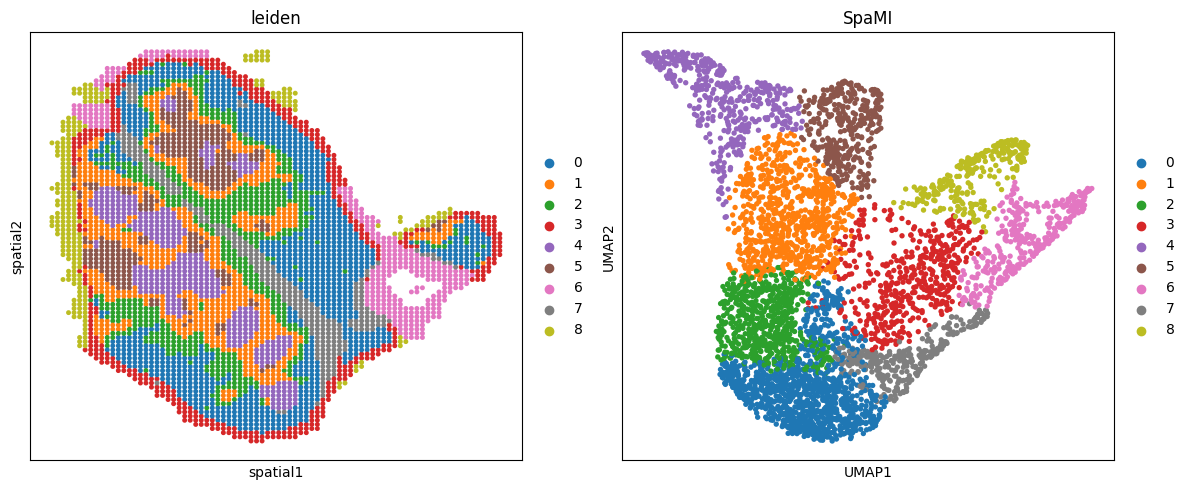

In [10]:
import matplotlib.pyplot as plt
fig, ax_list = plt.subplots(1, 2, figsize=(12, 5))

adata = AnnData(result)
adata.obsm['spatial'] = adata_omics1.obsm['spatial']
adata.obsm['spatial'][:, 1] = -adata.obsm['spatial'][:, 1]

sc.pp.pca(adata, n_comps=20)
sc.pp.neighbors(adata, n_neighbors=50, use_rep='X_pca')
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.55)
sc.pl.umap(adata, color='leiden', ax=ax_list[1], title='SpaMI', s=60, show=False)
sc.pl.embedding(adata, basis='spatial', color='leiden', ax=ax_list[0], size=50, show=False)

plt.tight_layout(w_pad=1)
plt.show()